In [1]:
import numpy as np
import pandas as pd
import pickle
import pydotplus
import seaborn as sns
import sys
import time
import warnings
import zipfile

from collections import (Counter,)
from imblearn.under_sampling \
    import (RandomUnderSampler,
            ClusterCentroids,
            TomekLinks,)
from imblearn.over_sampling \
    import (RandomOverSampler,
            SMOTE,)
from io import (StringIO,)
from IPython.display import (Image,)
from matplotlib import (pyplot as plt,)
from mlxtend.classifier import (StackingClassifier,)
from scipy import (stats,)
from scipy.cluster import (hierarchy as sch,)
from sklearn.cluster \
    import (KMeans,
            AgglomerativeClustering,)
from sklearn.datasets import (make_moons,)
from sklearn.decomposition import (PCA,) 
from sklearn.ensemble \
    import (AdaBoostClassifier,
            BaggingClassifier,
            ExtraTreesClassifier,
            GradientBoostingClassifier,
            RandomForestClassifier,
            VotingClassifier,)
from sklearn.feature_selection \
    import (chi2,
            f_regression,
            f_classif,
            RFE,
            SelectFromModel,
            SelectKBest,
            SelectPercentile,)
from sklearn.linear_model \
    import (Lasso,
            LogisticRegression,
            LinearRegression,
            Ridge,)
from sklearn.metrics \
    import (accuracy_score,
            auc,
            classification_report,
            confusion_matrix,
            f1_score,
            precision_score,
            precision_recall_fscore_support as error_metric,
            r2_score,
            recall_score,
            roc_auc_score,
            roc_curve,)
from sklearn.model_selection \
    import (GridSearchCV,
            RandomizedSearchCV,
            train_test_split,)
from sklearn.multiclass import (OneVsRestClassifier,)
from sklearn.neighbors import (KNeighborsClassifier,)
from sklearn.pipeline import (make_pipeline,)
from sklearn.preprocessing \
    import (LabelEncoder,
            MinMaxScaler,
            StandardScaler,)
from sklearn.svm \
    import (LinearSVC,
            LinearSVC,
            SVC,)
from sklearn.tree \
    import (DecisionTreeClassifier,
            DecisionTreeRegressor,)
from xgboost import (XGBClassifier,)

warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)

In [2]:
def plot_auc(y_test, y_pred):
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def get_scores(model, X_test, y_test,):
    y_pred = model.best_estimator_.predict(X_test,)
    print("Accuracy: {0}".format(accuracy_score(y_test, y_pred,)))
    print("\n")
    print("Recall: {0}".format(recall_score(y_test, y_pred,)))
    print("Precision: {0}".format(precision_score(y_test, y_pred,)))
    print("F1 Score: {0}".format(f1_score(y_test, y_pred,)))
    print("\n")
    print("ROC AUC: {0}".format(roc_auc_score(y_test, y_pred,)))
    print("\n")
    print("Confusion Matrix: \n{0}".format(confusion_matrix(y_test, y_pred,)))
    print("\n")
    print("Classification Report: \n{0}".format(classification_report(y_test, y_pred,)))
    plot_auc(y_test, y_pred)
    
def get_results_df(gscv_model,):
    # Creating a dictionary out of the GridSearchCV results
    results_dict = {}
    results = gscv_model.cv_results_
    
    for key in results.keys():
        if type(results[key]) == np.ndarray:
            results_dict[key] = list(results[key])
            
        elif type(results[key]) == np.ma.core.MaskedArray:
            results_dict[key] = list(results[key])
            
        elif type(results[key]) == list:
            pass
            # Accidentally wrote code for something that already exists.
            # Might as well keep it for later
#             if type(results[key][0]) == dict:
#                 cumulated_dict = {}
#                 for dict_key in results[key][0].keys():
#                     cumulated_dict[f'{key}_{dict_key}'] = []
#                 for dict_key in results[key][0].keys():
#                     for entry in results[key]:
#                         cumulated_dict[f'{key}_{dict_key}'].append(str(entry[dict_key]))
#                 for dict_key in results[key][0].keys():
#                     results_dict[f'{key}_{dict_key}'] = cumulated_dict[f'{key}_{dict_key}']
        else:
            print("Unkown type encountered")
        
    return_df = pd.DataFrame(data=results_dict,)
    
    if return_df.isnull().sum().max() > 0:
        print("Incorrect model training values have been omitted")
        print("{0} values".format(return_df.isnull().sum().max()))
    return_df.dropna(axis=0, inplace=True)
    
    return return_df

def train_model(model, hyperparameters, scoring_, filename):
    gscv_model = GridSearchCV(model, hyperparameters, cv=10, verbose=0, scoring=scoring_, n_jobs=-1, return_train_score=True,)

    try:
        with open(file_name, 'rb') as handle:
            gscv_model = pickle.load(handle)
        print("Found trained model file with same name. Loading it instead.")
    except:
        start_time = time.time()

        gscv_model.fit(X_train, y_train,)

        time_taken_s = np.around(time.time()-start_time, decimals=2,)
        time_taken_m = time_taken_s/60  
        print('Total Time taken = {0} seconds \nIn minutes: {1}'.format(time_taken_s, time_taken_m,))

        with open(file_name, 'wb') as handle:
            pickle.dump(gscv_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
    return gscv_model

def get_data(data_type_code):
    
    X_train, X_test, y_train, y_test = ["", "", "", "",]
    
    # Unmodified Data
    if data_type_code==1:
        X, y = pd.read_csv("X_cleaned.csv").iloc[:,1:], pd.read_csv("y_cleaned.csv").iloc[:,1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4, stratify=y,)
    
    # Undersample Data
    elif data_type_code==2:
#         X, y = pd.read_csv("X_undersampled.csv").iloc[:,1:], pd.read_csv("y_undersampled.csv").iloc[:,1]
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4, stratify=y,)
        X_train = pd.read_csv('X_train_undersampled.csv').iloc[:, 1:]
        X_test = pd.read_csv('X_test_undersampled.csv').iloc[:, 1:]
        y_train = pd.read_csv('y_train_undersampled.csv').iloc[:, 1]
        y_test = pd.read_csv('y_test_undersampled.csv').iloc[:, 1]
    
    # Oversampled Data
    elif data_type_code==3:
        X_train = pd.read_csv('X_train_oversampled.csv').iloc[:, 1:]
        X_test = pd.read_csv('X_test_oversampled.csv').iloc[:, 1:]
        y_train = pd.read_csv('y_train_oversampled.csv').iloc[:, 1]
        y_test = pd.read_csv('y_test_oversampled.csv').iloc[:, 1]
    
    # SMOTE Data
    elif data_type_code==4:
        X_train = pd.read_csv('X_train_smote.csv').iloc[:, 1:]
        X_test = pd.read_csv('X_test_smote.csv').iloc[:, 1:]
        y_train = pd.read_csv('y_train_smote.csv').iloc[:, 1]
        y_test = pd.read_csv('y_test_smote.csv').iloc[:, 1]
    
    else:
        raise Exception('Wrong Data Code')
        

    return [X_train, X_test, y_train, y_test]
    

$K$ $Nearest$ $Neighbors$

Total Time taken = 43.47 seconds 
In minutes: 0.7245
For unmodified data :
y_train: 35385
	Class 0: 34866, Class 1: 519
y_test: 15166
	Class 0: 14944, Class 1: 222
Accuracy: 0.9853619939337993


Recall: 0.0
Precision: 0.0
F1 Score: 0.0


ROC AUC: 0.5


Confusion Matrix: 
[[14944     0]
 [  222     0]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14944
           1       0.00      0.00      0.00       222

    accuracy                           0.99     15166
   macro avg       0.49      0.50      0.50     15166
weighted avg       0.97      0.99      0.98     15166



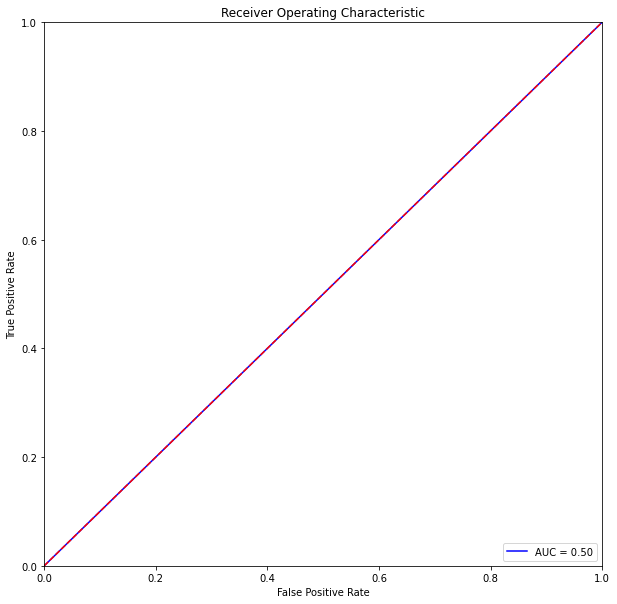

Total Time taken = 5.06 seconds 
In minutes: 0.08433333333333333
For undersampled data :
y_train: 1038
	Class 0: 519, Class 1: 519
y_test: 15166
	Class 0: 14944, Class 1: 222
Accuracy: 0.7702096795463537


Recall: 0.6801801801801802
Precision: 0.042356241234221596
F1 Score: 0.07974650118827568


ROC AUC: 0.7258636446939444


Confusion Matrix: 
[[11530  3414]
 [   71   151]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.77      0.87     14944
           1       0.04      0.68      0.08       222

    accuracy                           0.77     15166
   macro avg       0.52      0.73      0.47     15166
weighted avg       0.98      0.77      0.86     15166



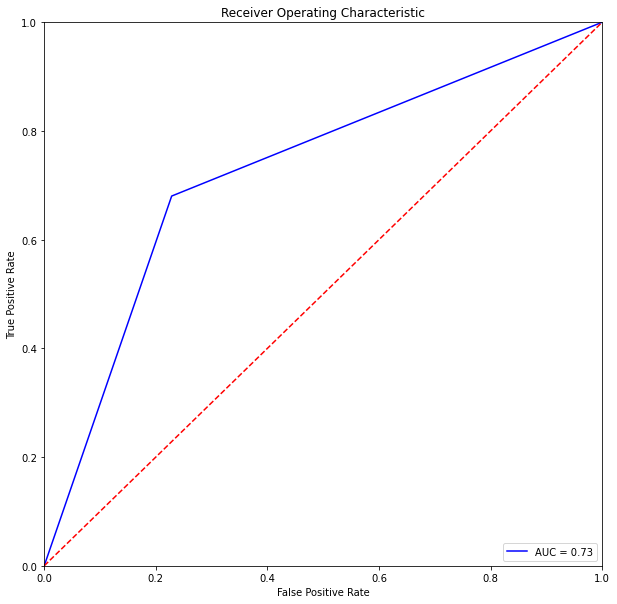

Total Time taken = 75.99 seconds 
In minutes: 1.2665
For oversampled data :
y_train: 69756
	Class 0: 34878, Class 1: 34878
y_test: 15166
	Class 0: 14932, Class 1: 234
Accuracy: 0.9256890412765396


Recall: 0.2606837606837607
Precision: 0.060098522167487685
F1 Score: 0.09767814251401122


ROC AUC: 0.598397063840407


Confusion Matrix: 
[[13978   954]
 [  173    61]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     14932
           1       0.06      0.26      0.10       234

    accuracy                           0.93     15166
   macro avg       0.52      0.60      0.53     15166
weighted avg       0.97      0.93      0.95     15166



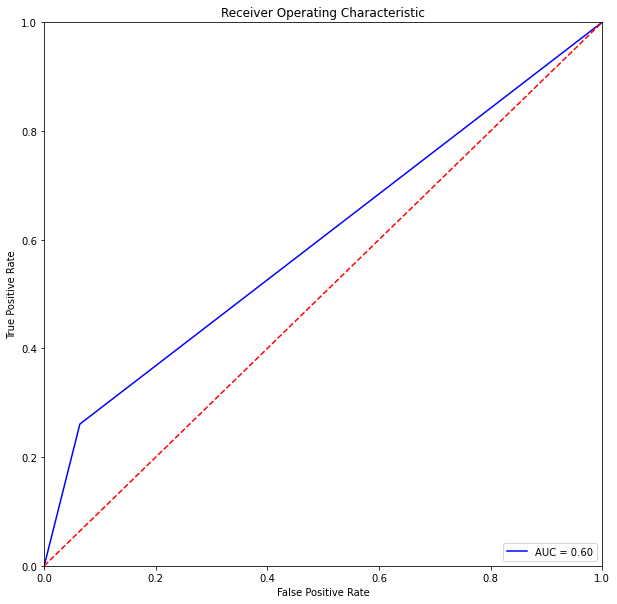

Total Time taken = 77.38 seconds 
In minutes: 1.2896666666666665
For smote data :
y_train: 69756
	Class 0: 34878, Class 1: 34878
y_test: 15166
	Class 0: 14932, Class 1: 234
Accuracy: 0.8918633786100488


Recall: 0.3803418803418803
Precision: 0.05618686868686869
F1 Score: 0.09790979097909791


ROC AUC: 0.6401106669322582


Confusion Matrix: 
[[13437  1495]
 [  145    89]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     14932
           1       0.06      0.38      0.10       234

    accuracy                           0.89     15166
   macro avg       0.52      0.64      0.52     15166
weighted avg       0.97      0.89      0.93     15166



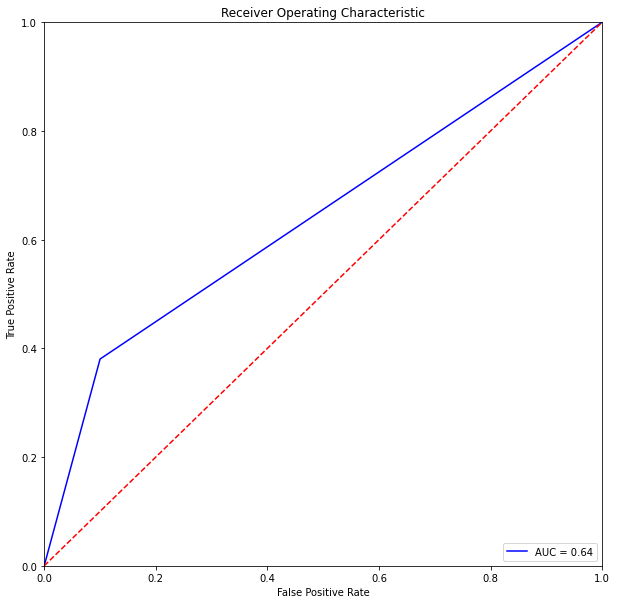

In [3]:
for data_code, code_string in zip(range(1,5), ['unmodified', 'undersampled', 'oversampled', 'smote']):
    
    X_train, X_test, y_train, y_test = get_data(data_code)

    model = KNeighborsClassifier()

    hyperparameters = {
        'n_neighbors': [2, 5, 10,],
        'algorithm': ['auto',],
        'p': [1, 2, 3,],
        'n_jobs': [-1],
    }

    scoring = "roc_auc"

    file_name = f'trained_model_knn_{data_code}{code_string}.pickle'

    gscv_model = train_model(model, hyperparameters, scoring, file_name,)
    
    print("="*60)
    print(f"For {code_string} data :")
    print(f'y_train: {len(y_train)}')
    print('\tClass 0: {0}, Class 1: {1}'.format(len(y_train[y_train==0]), len(y_train[y_train==1]),))
    
    print(f'y_test: {len(y_test)}')
    print(f'\tClass 0: {len(y_test[y_test==0])}, Class 1: {len(y_test[y_test==1])}')
    print("="*60)
    
    results_df = get_results_df(gscv_model)
#     print(results_df.head(4).T)
#     print(results_df.sort_values(by='rank_test_score', ascending=True).iloc[0,:].T)
    get_scores(gscv_model, X_test, y_test,)